# Assignment 1: Chinese character "detection"
LT2326, Autumn 2021

Name: Max Boholm (gusbohom)

# Introduction

This notebook cotains the code for *Assignment 1: Chinese character "detection"* for the course *Machine learning for statistical NLP: Advanced* (course code LT2326), Autumn 2021. The notebook is organized into the folowing parts:

*    Libraries
*    Meta variables (the term *hyperparameter* is here reserved for decisions on the models), which define ... the loacation (path) of the data, ... 
*    Data preparation
*    Definition and training of two models
*    Testing and evaluation
*    ...




# Libraries

In [1]:
import glob
import json
import random
import operator
import time
from math import sqrt

from PIL import Image
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.path as mplpath
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Meta variables

In [2]:
path = "../../../../../scratch/lt2326-h21/a1/"
#path = "../develop_util/"
images_dir = path + "images/"      # the directory of images to be data
meta_ctw   = path + "info.json"   # the (path to) the general meta file of CTW 
meta_train = path + "train.jsonl" # the (path to) the file containing the annotations of CTW training data

train_proportion = 0.7 # the proportion of training data; proportion of test data will be the complement of this number

device = torch.device("cuda:0")
#device = torch.device('cpu')

path_to_save_models = "../models/"
path_to_save_evaluations = "../evals/"

# For downsizing and restriction of dataset
# For not downsizing or no restriction of data use None

restriction = None # set to an integer, if subsample of the data is to be used in e.g. the development phase
rescale_input_to = 512 # preferably choose the rescale size from [1024, 512, 256]
rescale_output_to = 512

################################################################
#                                                              #
#  Note on rescaling: processes which are not convolutional    #
#  and handles 2048 x 2048 matrices are very time and memory   #
#  consuming (e.g. converting polygon coordinates to           #
#  0s-and-1s matrices and finding true positives, true         #
#  negatives, etc.). Therefore a large output can take alot    #
#  of time. With large inputs we will run out of memory on     # 
#  the CUDA, as the torch  tensors of the images will be too   #
#  large. Also, large inputs causes problems with scaling      #
#  (normalization).                                            #
#                                                              #
################################################################

## Part 1: data preparation

*Decision:* batching is kept as python `list` of tensors until feeding it to the model. This means that the training procedure, e.g. the models, must convert the batces to tensors.

### Definitions of functions

In [3]:
def only_train(file_dir = images_dir, meta_file = meta_ctw):
    """Tests whether image files in a directory is part of the training set of the CTW dataset, 
       as defined by the json metafile for CTW. Returns a list of filenames such that they are both
       in the specified directory and the CTW training set.
    """
    meta = json.load(open(meta_file,"r"))
    train_files_CTW = [entry["file_name"] for entry in meta["train"]]
    files_to_keep = []
    potential_files=[file.split("/")[-1] for file in glob.glob(file_dir+"*.jpg")]
    print("Potential files: ", len(potential_files))
    
    for file in potential_files:
        if file in train_files_CTW:
            files_to_keep.append(file)
    
    print("Kept files: ", len(files_to_keep))
    
    return files_to_keep

def shorty(files, restriction = restriction):
    """ Returns a shorter list of files picked by random.
    """
    
    if restriction != None:
        print("Warning: Now you have made a restriction to ", restriction, " files.")
        random.shuffle(files)
        r_files = files[:restriction]
    else:
        print("No restriction was made, since none was not specified.")
        r_files = files
    
    return r_files
        
def CTW_mapper(files, meta = meta_train):
    """ Identifies annotations for files from the training set of the CTW dataset. 
        Returns pyhoton dictionary that maps filenames (keys) with annotations (values), 
        which like in the original format is a list of lists of json elements / python dictinaries. 
    """
    mapping = {}
    with open(meta, "r") as f:
        annotations_data = [json.loads(line) for line in f.readlines()]
        for file in files:
            for annotation in annotations_data:
                if annotation["image_id"] == file[:-4]:
                    mapping[file] = annotation["annotations"]
                    break
    
    return mapping
                    
def img2array(file, directory = images_dir, rescale = rescale_input_to):
    """ Takes a filename of an image in a directory and returns an numpy array 
        corresponding to the image.
    """
    img = Image.open(directory+file)
    
    if rescale != None:
        img = img.resize((rescale, rescale))
    
    img = np.asarray(img)
    
    return img

def grid(height = 2048, width = 2048, rescale = rescale_output_to):
    """ Creates a grid (an array of coordinates) to be used in polygon2array 
        to speed things up.
    """
    
    if rescale != None:
        height = rescale
        width = rescale
        
    grid = np.array([[[h,w] for h in list(range(height))] for w in list(range(width))]).reshape(height*width, 2)
    
    return grid

def polygon2array(file, mapping, grid, height = 2048, width = 2048, rescale = rescale_output_to):
    """ Builds a matrix of 0s and 1s representing the character polygons as 
        defined by the coordinates of in the CTW annotations. 
    """
    
    # This takes long time :(
    
    polygons = []
    for block in mapping[file]: # mapping maps files with their annotations
        for character in block:
            if character["is_chinese"] == True:
                polygons.append(character["polygon"])
    
    if rescale != None:
        rescale_by = rescale / height # must come first
        height = rescale
        width = rescale
        polygons = [[[point * rescale_by for point in points] for points in set_of_points] for set_of_points in polygons]
    
    every_point = grid.copy()
    
    zeros_to_update = np.zeros(height * width)
    
    for polygon in polygons:
        path = mplpath.Path(np.array(polygon)) # can this be "sent" to Path in one go
        hits = np.asarray(path.contains_points(every_point), int)
        zeros_to_update += hits
    
    matrix = zeros_to_update.reshape(height, width)
    
    return matrix

def data_builder(files, directory, mapping):
    """ Compiles the dataset for use. Returns a list of dictionaties, such that each
        element of the list contains:
        -  the filename; key: "file"
        -  a vectorized instance of the training data; key: "img_vector"
        -  a vectorized instance of the labels, or targets (a vector of 0s and 1s indicating 
           boxes of characters in images); key: "label"
        
        Note: (1) the format of instances (training input and targets) are numpy arrays; and
        (2) the instances have "matrix shape". For these reasons, the output of the data_builder()
        requires further processing for it to be ready for pytorch processing. The functions 
        standardizer() and numpy2torch() is does required further down the pipline of data
        preprocessing.
    """
    t1 = time.perf_counter()
    my_grid = grid()
    data = []
    i=1 # for printing out progress
    for file in files: 
        instance = {}
        instance["file"] = file
        instance["img_vector"] = img2array(file)
        instance["label"] = polygon2array(file, mapping, grid = my_grid)
        data.append(instance)
        print("{}% done.".format(round((i/len(files))*100, 1)), end="\r")
        i+=1
        
    t2 = time.perf_counter()
    passed_time = t2 - t1
    print("Done! ({} m., {} s.)".format(int(passed_time/60), int(passed_time%60)))
   
    return data

def standardizer(dataset, scaler = StandardScaler()):
    """ Standardizes the image vectors of a dataset to z-scores using StandardScaler() 
        from the library sklearn.preprocessing. 
    """
    
    t1 = time.perf_counter()
    
    std_data = []
    example = dataset[0]["img_vector"]
    x, y, z = example.shape
    n_features = example.size # ... or x * y * z

    for instance in dataset:
        std_data.append(instance["img_vector"].reshape(n_features))

    scaled_data = scaler.fit_transform(std_data)

    for i, scaled_ins in enumerate(scaled_data):
        dataset[i]["img_vector"] = scaled_ins.reshape(x, y, z)
    
    t2 = time.perf_counter()
    passed_time = t2 - t1
    print("Done! ({} m., {} s.)".format(int(passed_time/60), int(passed_time%60)))    

def numpy2torch(dataset, device = device, permute = True):
    """ For a dataset, transforms its numpy arrays to torch tensors. If permute = True,
        image vectors are permuted such that ... 
    """
    
    t1 = time.perf_counter()
    
    for instance in dataset:
        if permute == True:  
            instance["img_vector"] = torch.tensor(instance["img_vector"], dtype=torch.float, device = device).permute(2,0,1)
        else:
            instance["img_vector"] = torch.tensor(instance["img_vector"], dtype=torch.float, device = device)
        instance["label"] = torch.tensor(instance["label"], dtype=torch.float, device = device)
    
    t2 = time.perf_counter()
    passed_time = t2 - t1
    print("Done! ({} m., {} s.)".format(int(passed_time/60), int(passed_time%60)))


### Calling functions: creating the overall dataset

In [4]:
files = only_train()

Potential files:  1000
Kept files:  845


In [5]:
len(files)

845

In [6]:
files = shorty(files)

No restriction was made, since none was not specified.


In [7]:
mapping = CTW_mapper(files)

In [8]:
my_data = data_builder(files, images_dir, mapping)

Done! (5 m., 17 s.)


In [9]:
len(my_data)

845

In [10]:
standardizer(my_data)

Done! (0 m., 19 s.)


In [11]:
numpy2torch(my_data)

Done! (0 m., 7 s.)


### Splitting the dataset into train and test sets

In [12]:
def split(data       = my_data, 
          train_prop = train_proportion,
          shuffle    = True,
          val_prop   = None):
    """ Splits a dataset into training data, testing data and, if selected,
        validation data. Note that the proportions of training data, test data
        and validation data (optional) must not exceed 100%. 
    """
    
    if shuffle == True:
        random.shuffle(data)
    
    if val_prop != None:
        train_to_idx = int(len(data) * train_prop)
        val_to_idx   = int(len(data) * val_prop) + train_to_idx
        train = data[:train_to_idx]
        val   = data[train_to_idx:val_to_idx]
        test  = data[val_to_idx:]
        return train, val, test
    else:
        train_to_idx = int(len(data) * train_prop)
        train = data[:train_to_idx]
        test  = data[train_to_idx:]
        return train, test

In [13]:
train_set, test_set = split() # there is no validation set used below... 

### Defining a dataloader
In training the models, the function `dataloader` will be called with the `train_set` in every iteration (epoch) yielding randomized and batched traing inputs. Note that the `dataloader` has a python `list` as basis for iteration, which requires special attention further down in the models and in the training loop in order to provide models with `pytorch` *tensors*. 

In [14]:
def dataloader(data, batch_size):
    """ Takes a  a dataset and returns a randomized iterator of
        the data organized into batches as defined by batch_size.
        
        Note: the dataloader preserves the "matrix shape" of trainingdata and 
        targets. Since pytorch neural networks require "flat" shapes of data
        the function flat_batch() is used to let data flow trough training
        in the desired format. 
    """
    
    random.shuffle(data)
    
    for group in [data[i : i+batch_size] for i in range(0, len(data), batch_size)]:
        files = []
        img_vecs = []
        labels = []

        for instance in group:
            files.append(instance["file"])
            img_vecs.append(instance["img_vector"])
            labels.append(instance["label"])

        batch = {"file":files, 
                 "img_vector":img_vecs, 
                 "label":labels}
    yield batch

## Part 2: the models

### General traing procedure

In [15]:
def flat_batch(batch):
    """Takes a python list of length B of more-than-one dimensional tensors (N, M, ...) and 
    returns a tensor of shape: (B, M*N*...). """
    
    return torch.stack([torch.flatten(instance) for instance in batch])

In [16]:
def trainer(model, # Must be an instance of a model!
            name_of_model,
            learning_rate,
            epochs,
            batch_size,
            train_data = train_set,
            val_data = None,
            save_model = False,
            directory = path_to_save_models,
            #my_loss_function = nn.MSELoss,
            my_loss_function = nn.BCELoss,
            my_optimizer = optim.Adam
           ):
    """ Specifices a general training procedure for a model. 
        Note: trainer() requires an instantiated model as model argument. 
    """
    
    optimizer = my_optimizer(model.parameters(), lr=learning_rate)    
    
    model.to(device)
    model.train()
    
    loss_function = my_loss_function()
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        iterator = dataloader(train_set, batch_size)
        for i, batch in enumerate(iterator):
            optimizer.zero_grad # reset gradients
            output = model(batch["img_vector"])
            targets = flat_batch(batch["label"])
            loss = loss_function(output, targets)
            epoch_loss += loss.item()
            loss.backward() # compute gradients
            optimizer.step() # update parameters
            #break
            
        print(f"Epoch: {epoch+1} (out of {epochs}); total loss: {epoch_loss}.")
            
        if val_data != None:
            model.eval()
            # Here we could do some evaluation of model progress, but I have ignored this for now. 
            model.train()
            
    if save_model == True:
        torch.save(model, directory+name_of_model+".pt")

### Model 1: Convolutional Model with Upsampling (CUP)

In [ ]:
class CUP(nn.Module):
    def __init__(self, inp_height, inp_width, ch, outp):   
        super(CUP, self).__init__()
        
        self.height = inp_height
        self.width = inp_width
        self.channels = ch
        self.output = outp

        self.compression = nn.Sequential(      # convolution0, a major size reduction
            nn.Conv2d(in_channels = 3, 
                      out_channels = 3, 
                      kernel_size = 4, 
                      stride = 4, 
                      padding = 0),
            nn.BatchNorm2d(3),
            nn.RReLU(),
            nn.MaxPool2d(4, 4)
        )
        
        self.convolution1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,     
                      out_channels = self.channels[0], 
                      kernel_size = 4,     
                      stride = 1, 
                      padding = "same"), 
            nn.RReLU(),
            nn.MaxPool2d(2, 2), # 2x2 window with stride of 2
        )
        
        self.convolution2 = nn.Sequential(
            nn.Conv2d(in_channels = self.channels[0],     
                      out_channels = self.channels[1], 
                      kernel_size = 2,     
                      stride = 1, 
                      padding = "same"), 
            nn.RReLU(),
            nn.MaxPool2d(2, 2), # 2x2 window with stride of 2
        )
        
        # Example with 2048 x 2048 images:
        # [batch_n, 3, 2048, 2048] --> [batch_n, 3, 128, 128] (compression by convolution and max pooling)
        # [batch_n, 3, 128,  128]  --> [batch_n, 32, 64,  64]  (convolution1)
        # [batch_n, 32, 64,   64]  --> [batch_n, 64, 32,  32]  (convolution2)
        # 64*32*32 = 65536
        # 2048 * 2048 (= 4194304 i.e. target_size) / 65536 = 64 (i.e. the number that our tensor need to be upsampled by)
        # sqrt(64) = 8 (the upsampling will be applied to both heigt and weigth)
        
        self.up_factor = sqrt(self.output/(self.channels[1]*((self.height / (16*2*2))**2)))
        
        self.exit = nn.Sequential(
            nn.Dropout(0.10), 
            nn.Upsample(scale_factor=self.up_factor, mode='bilinear'), #decide on mode
            nn.Flatten(), # by default start_dim = 1
            nn.Sigmoid()
        )
        
    def forward(self, batch):
        if isinstance(batch, list):    # this is admittedly a bit ad hoc, but it handles the format of the batched training data and the non-batched evaluation data; and it works ;)
            batch = torch.stack(batch) 
        else:
            batch = torch.stack([batch])
        
        features0 = self.compression(batch)
        features1 = self.convolution1(features0)
        features2 = self.convolution2(features1)
        output = self.exit(features2)
        
        return output

#### Training and saving model

In [ ]:
shape_of_input = my_data[0]["img_vector"].shape
height = shape_of_input[1]
width = shape_of_input[2]
shape_of_output = my_data[0]["label"].shape
output_size = shape_of_output[0] * shape_of_output[1]

my_cup_model = CUP(inp_height = height, 
                   inp_width = width, 
                   ch = (8,16), #for [2048, 1024, 512, 256] images choose channel[1] as one of [4, 16, 64]
                   outp = output_size)

In [ ]:
my_cup_model.parameters

In [ ]:
nepochs = 200
batchsz = 128

sample = len(my_data)  
inp_rsc = 2048 if rescale_input_to == None else rescale_input_to
out_rsc = 2048 if rescale_output_to == None else rescale_output_to

cup_name = f"CUP{inp_rsc}to{out_rsc}_e{nepochs}b{batchsz}_n{sample}"

trainer(my_cup_model, # Must be an instance of a model!
        cup_name,
        learning_rate=0.001,
        epochs=nepochs,
        batch_size=batchsz,
        save_model = True)

### Model 2: Convolutional Diabolo Model

In [17]:
# Inspiration for this model was found here: 
# https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

class Diabolo(nn.Module):
    def __init__(self, inp_dim, outp):   
        super(Diabolo, self).__init__()
        
        self.input_dimension = inp_dim
        self.output = outp

        self.encoder = nn.Sequential(         # C1
            nn.Conv2d(in_channels = 3, 
                      out_channels = 8, 
                      kernel_size = 16, 
                      stride = 8, 
                      padding = 4),      
            nn.ReLU(), 
            nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 3, 1, padding = "same"), # C2
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, 1, padding = "same"),  # C3
            nn.ReLU(), 
            nn.MaxPool2d(2,2))
        
        # Encoded size: [n_batch, channels[-1], (heigth / x), (width / x)], 
        # where x = compression from C1 * compression from C2 * compression from C3,
        # which equals: 8 * 2 * 2 * 2. For calculating the compression of C1 we can
        # use the formula: 
        #                         (input dimension + 2*padding - kernel size)
        #     output dimension =  ______________________________________________ + 1
        #                                        stride
        #   
        # With the parameters of C1, input dimension dived by output dimension equals a 
        # a reduction by 8; which is then followed by three 2x2 maxpoolings with stride
        # of 2 (i.e. 2**3). For example, for an input of 2048, we get: 2048 (C1)>>> 
        # ((2048 + 2*8 - 16) / 7 )+1 = 256 (max pool)>>> 128 (max pool)>>> 64 (max pool)>>> 32
        # Thus, for input sized 2048 x 2048, encoded size will be: [n_batch, 64, 32, 32].
        
        dim_after_C1 = ((self.input_dimension + 2*4 - 16) / 8) + 1
        reduction_C1 = self.input_dimension / dim_after_C1
        
        self.encoded_dim = self.input_dimension / (reduction_C1 * 2**3)
            # see example above: input_size / (8 * 2 * 2 * 2)

        self.factor      = (sqrt(self.output)/self.encoded_dim)/32
        
        # This manouver to define a factor relative the input and output enables us 
        # to streamline the model such that it can handle different inputs and outputs. 
        # As defined below, the first layer of the decoder, outputs the SAME shape from
        # different dimensions of the encoded representation (eg. 32, 16, 8). However, 
        # from a machine learning perspective this approach is admittedly ad hoc. There 
        # little theoretical motivation for why we should use larger kernels, strides 
        # and padding for smaller inputs.
        
        self.decoder = nn.Sequential(                  
            nn.ConvTranspose2d(32, 16, 4, 2, padding=1), # D1
            nn.BatchNorm2d(16),            
            nn.ConvTranspose2d(16, 8, 4, 2, padding=1),  # D2
            nn.BatchNorm2d(8),  
            nn.ConvTranspose2d(8, 3, 4, 2, padding=1),   # D3
            nn.BatchNorm2d(3), 
            nn.ConvTranspose2d(3, 1, 4, 2, padding=1),   # D4; dimension to aim for is sqrt(self.output)
            nn.ConvTranspose2d(in_channels = 1,          # D5
                               out_channels = 1, 
                               kernel_size = int(4*self.factor), 
                               stride = int(2*self.factor), 
                               padding = int(1*self.factor)), 
            nn.Flatten(), 
            nn.Sigmoid()
            )
            
    def forward(self, batch):
        if isinstance(batch, list):    # this is admittedly ad hoc, but it handles the format of the batched training data and the non-batched evaluation data; and it works ;)
            batch = torch.stack(batch) 
        else:
            batch = torch.stack([batch])
            
        encoded = self.encoder(batch)
        output  = self.decoder(encoded)
        
        return output

In [18]:
shape_of_input = my_data[0]["img_vector"].shape
input_dimension = shape_of_input[1]
shape_of_output = my_data[0]["label"].shape
output_size = shape_of_output[0] * shape_of_output[1]

my_diabolo_model = Diabolo(input_dimension, output_size)

In [19]:
my_diabolo_model.parameters

<bound method Module.parameters of Diabolo(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(16, 16), stride=(8, 8), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(8, eps=1e-05, mo

In [21]:
nepochs = 200
batchsz = 128

sample = len(my_data)  
inp_rsc = 2048 if rescale_input_to == None else rescale_input_to
out_rsc = 2048 if rescale_output_to == None else rescale_output_to

diab_name = f"Diabolo{inp_rsc}to{out_rsc}_e{nepochs}b{batchsz}_n{sample}"

trainer(my_diabolo_model, # Must be an instance of a model!
        diab_name,
        learning_rate=0.001,
        epochs=nepochs,
        batch_size=batchsz,
        save_model = True)

Epoch: 1 (out of 200); total loss: 0.09574724733829498.
Epoch: 2 (out of 200); total loss: 0.09652231633663177.
Epoch: 3 (out of 200); total loss: 0.09450240433216095.
Epoch: 4 (out of 200); total loss: 0.08954591304063797.
Epoch: 5 (out of 200); total loss: 0.09163869172334671.
Epoch: 6 (out of 200); total loss: 0.08896605670452118.
Epoch: 7 (out of 200); total loss: 0.0892222672700882.
Epoch: 8 (out of 200); total loss: 0.08554583042860031.
Epoch: 9 (out of 200); total loss: 0.0827312096953392.
Epoch: 10 (out of 200); total loss: 0.08183666318655014.
Epoch: 11 (out of 200); total loss: 0.0860547125339508.
Epoch: 12 (out of 200); total loss: 0.08129052817821503.
Epoch: 13 (out of 200); total loss: 0.08266719430685043.
Epoch: 14 (out of 200); total loss: 0.08043531328439713.
Epoch: 15 (out of 200); total loss: 0.07957178354263306.
Epoch: 16 (out of 200); total loss: 0.07808996737003326.
Epoch: 17 (out of 200); total loss: 0.07660899311304092.
Epoch: 18 (out of 200); total loss: 0.07464

Epoch: 145 (out of 200); total loss: 0.03601260110735893.
Epoch: 146 (out of 200); total loss: 0.03625793009996414.
Epoch: 147 (out of 200); total loss: 0.0344155952334404.
Epoch: 148 (out of 200); total loss: 0.03197207674384117.
Epoch: 149 (out of 200); total loss: 0.03303757682442665.
Epoch: 150 (out of 200); total loss: 0.03737587481737137.
Epoch: 151 (out of 200); total loss: 0.03455023840069771.
Epoch: 152 (out of 200); total loss: 0.04891480505466461.
Epoch: 153 (out of 200); total loss: 0.03831224888563156.
Epoch: 154 (out of 200); total loss: 0.03060067445039749.
Epoch: 155 (out of 200); total loss: 0.03778675198554993.
Epoch: 156 (out of 200); total loss: 0.040584418922662735.
Epoch: 157 (out of 200); total loss: 0.03990611061453819.
Epoch: 158 (out of 200); total loss: 0.04218897596001625.
Epoch: 159 (out of 200); total loss: 0.0393831841647625.
Epoch: 160 (out of 200); total loss: 0.04093100130558014.
Epoch: 161 (out of 200); total loss: 0.040740400552749634.
Epoch: 162 (ou

## Part 3: testing and evaluation

### Evaluation Metrics

In [22]:
def thld_metrics(tp, fp, tn, fn):
    """ Threshold metrices. Calculates Accuracy, Recall, Precision, and F1 from frequencies of 
        true postives (tp), false postives (fp), true negatives (tn), and
        false neagtives (fn).
    """
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = (2 * recall * precision) / (recall + precision)
    return accuracy, recall, precision, f1

In [23]:
def mean(array):
    """ Calculates the mean and standard deviation of an aray of numbers.
    """
#     print(array)
    mean = np.mean(array)
    std  = np.std(array)
    return mean, std

### A class to store and handle evaluations

In [24]:
class Evaluation:
    """ For storing and handling information from the evaluation of models.
    """
    
    def __init__(self, name):
        self.name = name
        self.pooled_mse = "Not yet defined"
        self.pooled_acc = "Not yet defined"
        self.pooled_rec = "Not yet defined"
        self.pooled_prc = "Not yet defined"
        self.pooled_f1  = "Not yet defined"
        self.mean_mse = ("Not yet defined", "Not yet defined")
        self.mean_acc = ("Not yet defined", "Not yet defined")
        self.mean_rec = ("Not yet defined", "Not yet defined")
        self.mean_prc = ("Not yet defined", "Not yet defined")
        self.mean_f1  = ("Not yet defined", "Not yet defined")
        self.metrics_dict = {"mse": ["Not yet defined", "Not yet defined"], "accuracy": ["Not yet defined", "Not yet defined"], "recall": ["Not yet defined", "Not yet defined"], "precision": ["Not yet defined", "Not yet defined"], "f1": ["Not yet defined", "Not yet defined"]}

    def best_case(self, metric):
        """ Returns the file which has the best performance score with respect 
            to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=True)
        return m_list[0][0]
    
    def best_cases(self, metric, n):
        """ Returns a list of the N files which has the best performance score 
            with respect to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=True)
        files, values = zip(*m_list)
        return list(files[:n])
    
    def worst_case(self, metric):
        """ Returns the file which has the best performance score with respect 
            to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=False)
        return m_list[0][0]

    def worst_cases(self, metric, n):
        """ Returns a list of the N files which has the best performance score 
            with respect to a metric.
        """
        m_list = self.metrics_dict[metric]
        m_list.sort(key=operator.itemgetter(1), reverse=False)
        files, values = zip(*m_list)
        return list(files[:n])
    
    def compare(self, other_model):
        """ Compares the evaluation of one model with another.
        """
        pass
    
    def summary(self):
        """ Summarises an evaluation. Returns string."""
        summary  = "\n".join([f"Model {self.name} performs as follows:", 
                      f"Pooled MSE: {self.pooled_mse}",
                      f"Pooled Accuracy: {self.pooled_acc}",
                      f"Pooled Recall: {self.pooled_rec}",
                      f"Pooled Precision: {self.pooled_prc}",
                      f"Pooled F1: {self.pooled_f1}",
                      f"Mean MSE: {self.mean_mse[0]} (std = {self.mean_mse[1]})",
                      f"Mean Accuracy: {self.mean_acc[0]} (std = {self.mean_acc[1]})",
                      f"Mean Recall: {self.mean_rec[0]} (std = {self.mean_rec[1]})",
                      f"Mean Precision: {self.mean_prc[0]} (std = {self.mean_prc[1]})",
                      f"Mean F1: {self.mean_f1[0]} (std = {self.mean_f1[1]})"]) 
        return summary
    
    def save(self, directory=path_to_save_evaluations):
        """ Writes the summary of an evaluation to a text file (at some diectory)."""
        
        summary = self.summary()
        with open(directory+self.name+".txt", "w") as e:
            e.write(summary)
    
    def print_summary(self):
        """ Prints out the summary of an evaluation.
        """
        summary = self.summary()
        print(summary)
    

### Evaluation: performance of best models

In [25]:
def evaluator(model, name, test_data = test_set, threshold = 0.5, detach_me=False):
    """ Defines a general pipeline for evaluation by Mean Squared Error (MSE); and optionally
        Accuracy, Recall, Precison and F1 (these calculations are time consuming). The evaluator()
        function implements the Evaluation class to store and handle informaion from the evaluation. 
        For each metric, there is a value calculated for the test data as a whole ("pooled") and an 
        average value calculated over the set of values calculated for each image individually. 
        Besides an instance of the Evaluation class, evaluator() returns a mapping between files and 
        the predicted outcome for that file.
        
        Note: change parameter threshold to None for ignoring threshold metrices.
    """
    t1 = time.perf_counter()
    
    model.eval()
    
    evaluation = Evaluation(name)
    
    prediction_pooled = []
    truth_pooled = [] 
    thld_frequencies_pooled = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
    thld_metrics_calc = {"mse": [], "accuracy": [], "recall": [], "precision": [], "f1": []}

    i=1 # in order to print out progress
    for instance in test_data:
        
        if detach_me == True:
            prediction = torch.flatten(model(instance["img_vector"])).detach().to("cpu") # due to design of model
            truth = torch.flatten(instance["label"]).int().detach().to("cpu")
            file = instance["file"]
        
        else:
            prediction = torch.flatten(model(instance["img_vector"])) # due to design of model
            truth = torch.flatten(instance["label"]).int()
            file = instance["file"]
            
        prediction_pooled.append( (file, prediction) )
        truth_pooled.append(truth)        
        
        mse = F.mse_loss(prediction, truth)
        thld_metrics_calc["mse"].append( (file, mse.item()) )
        
        #######
        #roundof = (prediction >= 0.1).int()
        #print("sum of roundof, file:", file, torch.sum(roundof))
        #break
        #######
        
        # IF-block for calculating accuracy, recall, precision, f1, which is very
        # time consuming, due to identifications of TPs, FPs, TNs, and FNs for 
        # large matrices.
        if threshold != None:
            roundof = (prediction >= threshold).int()
            #print("sum of roundof", torch.sum(roundof))
            tp = sum(roundof * truth)
            fp = sum(roundof * (~truth.bool()))
            tn = sum((~roundof.bool()) * (~truth.bool()))
            fn = sum((~roundof.bool()) * truth)

            accuracy, recall, precision, f1 = thld_metrics(tp, fp, tn, fn)

            for key, value in zip(["tp", "fp", "tn", "fn"], [tp, fp, tn, fn]):
                thld_frequencies_pooled[key]+=value

            for key, value in zip(["accuracy", "recall", "precision", "f1"], 
                                  [accuracy.item(), recall.item(), precision.item(), f1.item()]):
                thld_metrics_calc[key].append( (file, value) )
        
        print("({}%)".format(round((i/len(test_data)*100), 1)), end="\r")
        i+=1
    
    file, predictions = zip(*prediction_pooled)
    evaluation.pooled_mse = F.mse_loss(torch.flatten(torch.stack(list(predictions))), 
                                       torch.flatten(torch.stack(truth_pooled))).item()
    
    if threshold != None:
        pooled_accuracy, pooled_recall, pooled_precision, pooled_f1 = thld_metrics(
            thld_frequencies_pooled["tp"], 
            thld_frequencies_pooled["fp"], 
            thld_frequencies_pooled["tn"], 
            thld_frequencies_pooled["fn"])
        
        evaluation.pooled_acc = pooled_accuracy
        evaluation.pooled_rec = pooled_recall
        evaluation.pooled_prc = pooled_precision
        evaluation.pooled_f1  = pooled_f1
    
    # The code below is a bit nested. What it does in plain English is:
    # go to the dictionary where we keep all the performance scores with respect to 
    # each file. Every key (i.e. metric) of that dict maps to a list of tupples of 
    # file and value of the metric. Here, we "unzip" that list of tupples and calculate the 
    # mean (and standard deviation) for the values and use that mean (and std) to define 
    # the respective attributes of the Evaluation class instance.
    
    evaluation.mean_mse = mean(list(zip(*thld_metrics_calc["mse"]))[1])
    
    if threshold != None:
        evaluation.mean_acc = mean(list(zip(*thld_metrics_calc["accuracy"]))[1]) 
        evaluation.mean_rec = mean(list(zip(*thld_metrics_calc["recall"]))[1]) 
        evaluation.mean_prc = mean(list(zip(*thld_metrics_calc["precision"]))[1]) 
        evaluation.mean_f1  = mean(list(zip(*thld_metrics_calc["f1"]))[1]) 
    
    evaluation.metrics_dict = thld_metrics_calc
    
    t2 = time.perf_counter()
    passed_time = t2 - t1
    print("Done! ({} m., {} s.)".format(int(passed_time/60), int(passed_time%60)))
    
    return evaluation, dict(prediction_pooled)

#### CUP model

In [ ]:
# If we want to revisit the performance of a trained and saved model with its evaluation data
from datetime import date
today = date.today()

eval_files = [instance["file"] for instance in test_set]
with open(path_to_save_evaluations + f"evfiles{cup_name}{today.strftime("%d-%m-%Y")}.txt", "w") as file:
    file.write("\n".join(eval_files))

In [ ]:
evaluation_cup, file2pred_map = evaluator(my_cup_model, cup_name, threshold = 0.5)

In [ ]:
evaluation_cup.print_summary()

In [ ]:
my_best_file = evaluation_cup.best_case("mse")

In [ ]:
my_worst_file = evaluation_cup.worst_case("mse")

In [ ]:
evaluation_cup.save()

#### Diabolo model

In [27]:
# If we want to revisit the performance of a trained and saved model with its evaluation data
eval_files = [instance["file"] for instance in test_set]
with open(path_to_save_evaluations + f"evfiles{diab_name}.txt", "w") as file:
    file.write("\n".join(eval_files))

In [28]:
evaluation_diabolo, file2pred_map = evaluator(my_diabolo_model, 
                                              diab_name, 
                                              detach_me=True)

Done! (21 m., 16 s.)


In [29]:
evaluation_diabolo.print_summary()

Model Diabolo512to512_e200b128_n845 performs as follows:
Pooled MSE: 0.00515931099653244
Pooled Accuracy: 0.9948955774307251
Pooled Recall: 0.0
Pooled Precision: nan
Pooled F1: nan
Mean MSE: 0.005159311266945983 (std = 0.005609450226221853)
Mean Accuracy: 0.9948955896332508 (std = 0.005598291456024537)
Mean Recall: 0.0 (std = 0.0)
Mean Precision: nan (std = nan)
Mean F1: nan (std = nan)


In [53]:
my_best_file = evaluation_diabolo.best_case("mse")

In [54]:
my_worst_file = evaluation_diabolo.worst_case("mse")

In [32]:
evaluation_diabolo.save()

In [46]:
# A little test

shape_of_input = my_data[0]["img_vector"].shape
input_dimension = shape_of_input[1]
shape_of_output = my_data[0]["label"].shape
output_size = shape_of_output[0] * shape_of_output[1]

miffo = Diabolo(input_dimension, output_size)
miffo.to(device)
#print(miffo.parameters)

_my_test_files = test_set[:2]

evm, fpm = evaluator(miffo, "miffo", test_data = _my_test_files)
evm.print_summary()

Done! (0 m., 17 s.)
Model miffo performs as follows:
Pooled MSE: 0.2608216404914856
Pooled Accuracy: 0.030752182006835938
Pooled Recall: 0.963661789894104
Pooled Precision: 0.002706617582589388
Pooled F1: 0.005398073233664036
Mean MSE: 0.260821670293808 (std = 1.2218952178955078e-06)
Mean Accuracy: 0.030752182006835938 (std = 5.53131103515625e-05)
Mean Recall: 0.963623434305191 (std = 0.0032273828983306885)
Mean Precision: 0.0027066179318353534 (std = 4.123884718865156e-05)
Mean F1: 0.005398071836680174 (std = 8.206721395254135e-05)


In [48]:
evm.best_case("recall")

'1002267.jpg'

### Visualizations

In [49]:
def visualize(file, 
              file2prediction, 
              file2annotation, # the mapping of files with their annotations was defined above
              height = 2048, 
              width = 2048, 
              rescale = rescale_output_to,
              img_dir = images_dir, 
              colorscheme = "Reds", 
              alpha_value = 0.3):
    """ Visualizes the performance of a model on a particular image.
    """
    
    # FIRST, collect elements of figure
    img = Image.open(img_dir+file)
    if rescale != None:
        img = img.resize((rescale, rescale))
    
    if rescale != None:
        rescale_by = rescale / height # must come first
        height = rescale
        width = rescale

    polygons = []
    for block in file2annotation[file]:  
        for character in block:
            if character["is_chinese"] == True:
                polygons.append(character["polygon"])
    
    if rescale != None:
        polygons = [[[point * rescale_by for point in points] for points in set_of_points] for set_of_points in polygons]
    
    cpu_tensor = file2prediction[file].cpu().detach().numpy()
    heat = cpu_tensor.reshape(height, width)
    #heat = file2prediction[file].reshape(height, width).detach().numpy()
    
    # SECOND, arrange and plot elements in 2 x 2 subplots
    
    %matplotlib inline
    
    figure = plt.figure(figsize=(16, 16))
    
    #Up-Left
    axUL = figure.add_subplot(221)
    axUL.set_title("True polygon box on image (Target)")
    axUL.imshow(img)
    for polygon in polygons:
        polly = Polygon(polygon, fill = False, color = (0, 1, 0)) # Recall that Polygon is a method of matplotlib.patches
        axUL.add_patch(polly)

    #Up-Right
    axUR = figure.add_subplot(222)
    axUR.set_title("Predicted heatmap on image (Result)")
    axUR.imshow(img)
    axUR.imshow(heat, cmap = colorscheme, alpha = alpha_value)

    #Down-Left
    axDL = figure.add_subplot(223)
    axDL.set_title("Image, Target and Result")
    axDL.imshow(img)
    axDL.imshow(heat, cmap = colorscheme, alpha = alpha_value)
    for polygon in polygons:
        polly = Polygon(polygon, fill = False, color = (0, 1, 0))
        axDL.add_patch(polly)

    #Down-Right
    axDR = figure.add_subplot(224)
    axDR.set_title("True box on predicted heatmap (Abstraction)")
    axDR.imshow(heat, cmap = colorscheme, alpha = alpha_value)
    for polygon in polygons:
        polly = Polygon(polygon, fill = False, color = (0, 1, 0))
        axDR.add_patch(polly)

    plt.show()

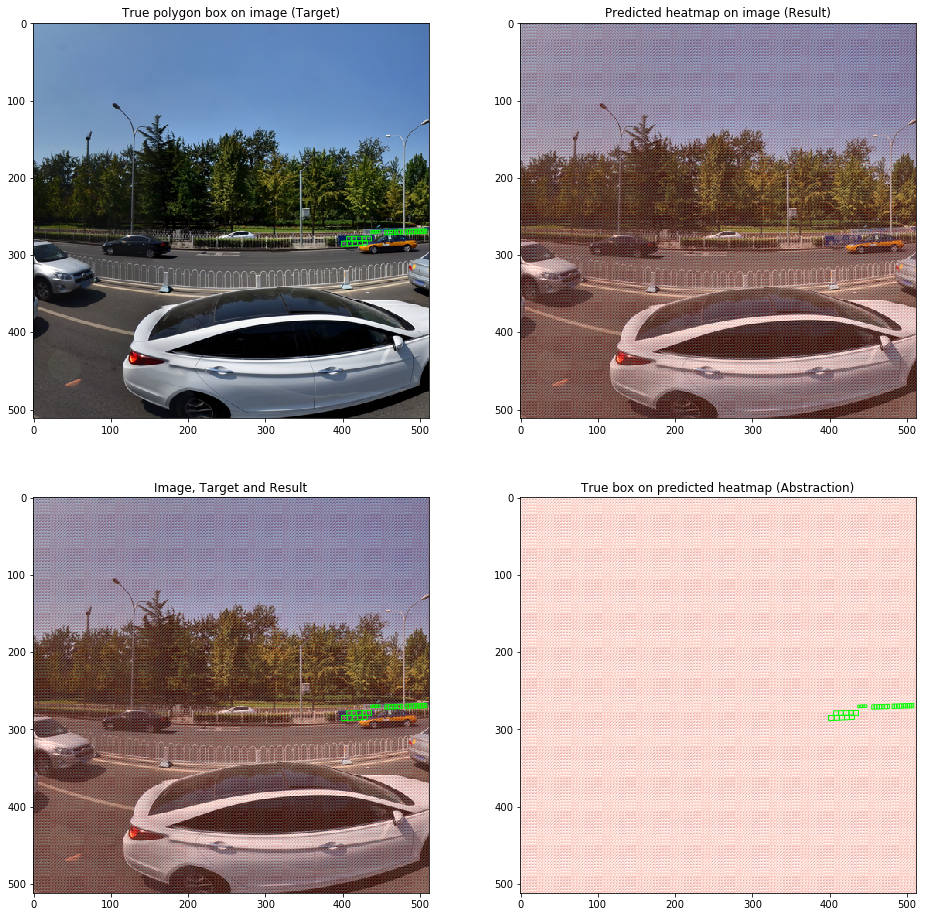

In [50]:
visualize('1002267.jpg', fpm, mapping)

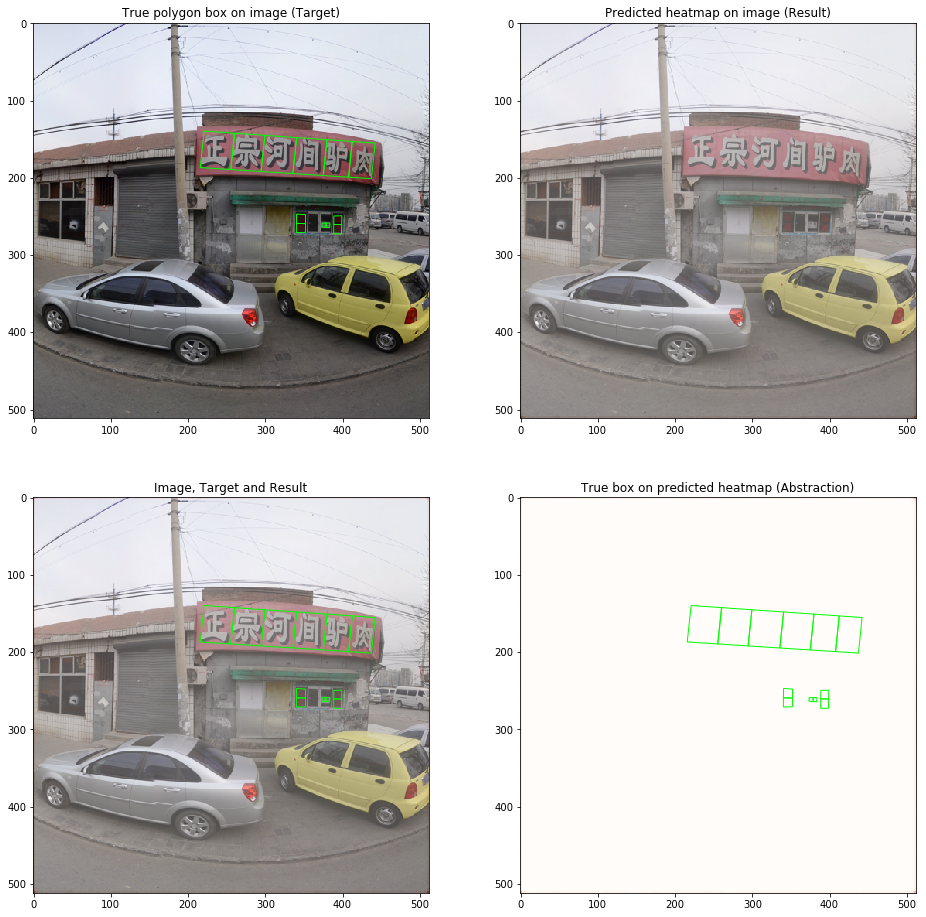

In [55]:
visualize(my_best_file, file2pred_map, mapping)

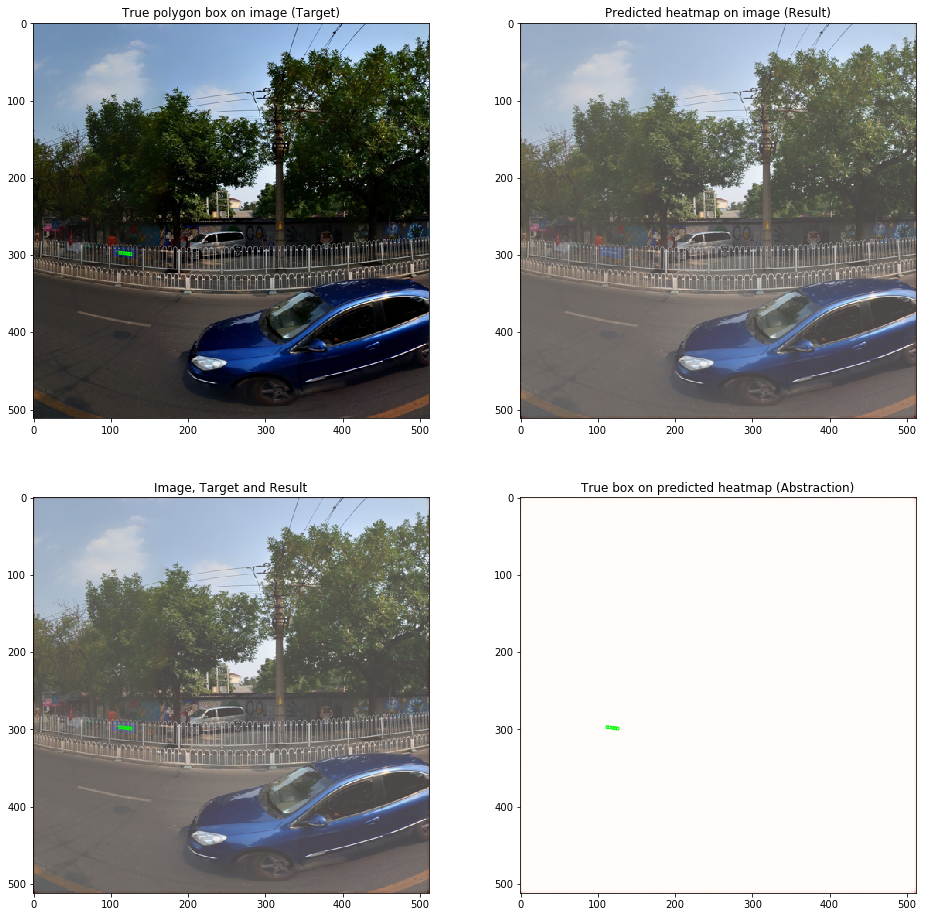

In [56]:
visualize(my_worst_file, file2pred_map, mapping)